<center><img src="https://pbs.twimg.com/media/DzK7Z1zXcAAeQQM.jpg" style="width:100%;height:100%;">
</center>

# Table of Contents
1. [**Packages**](#section1)
2. [**How to create a map using ggplot2**](#section2)
3. [**Election Data & First Map**](#section3)
4. [**Trump vs Clinton**](#section4)
5. [**Statebins**](#section5)
6. [**References**](#section6)

<a id="section1"></a>
# 1.Packages

In [1]:
library(tidyverse)
library(maps)
#install.packages("mapproj")
library(png)
library(grid)
library(cowplot)
install.packages("statebins")
library(statebins)
library(DT)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.2          ✔ dplyr   1.0.0     
✔ tidyr   1.1.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



<a id="section2"></a>
# 2.How to create a map using ggplot2

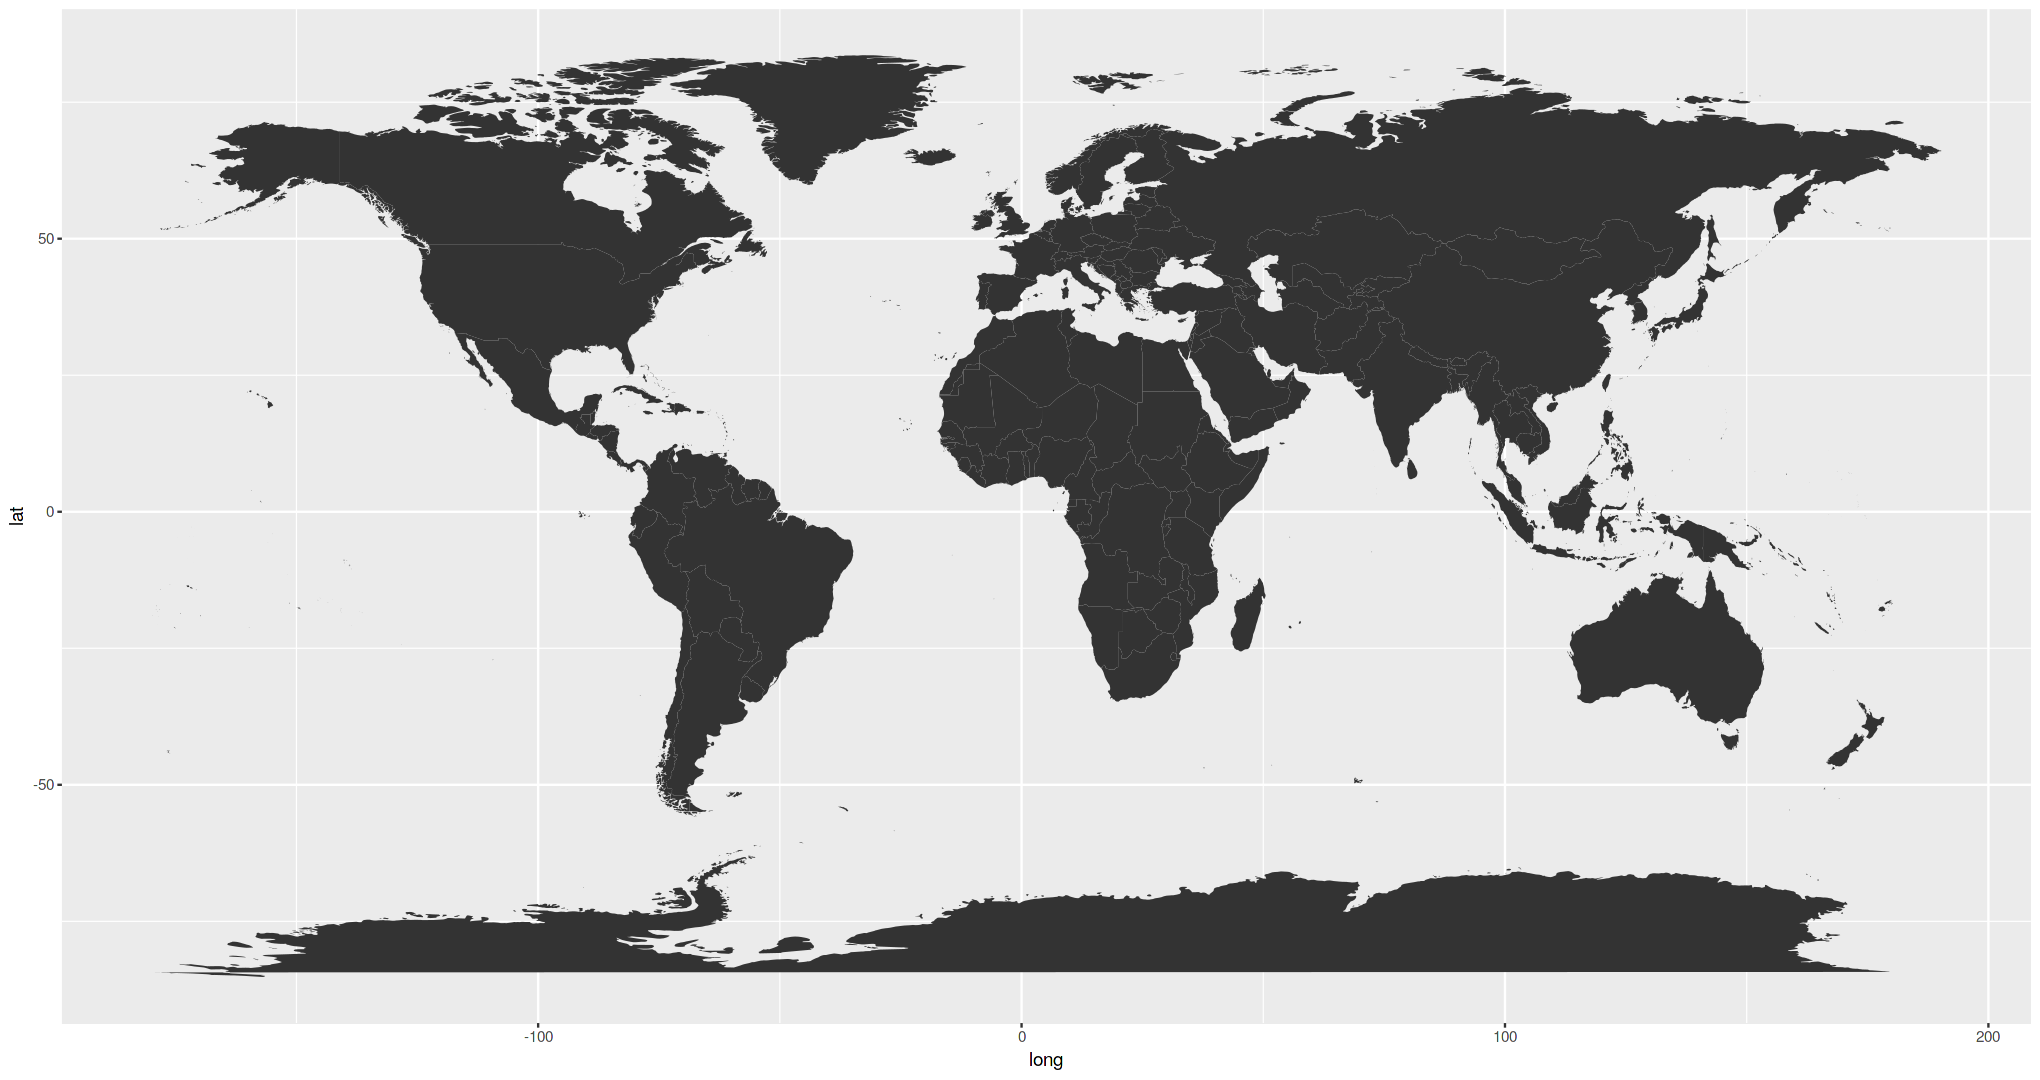

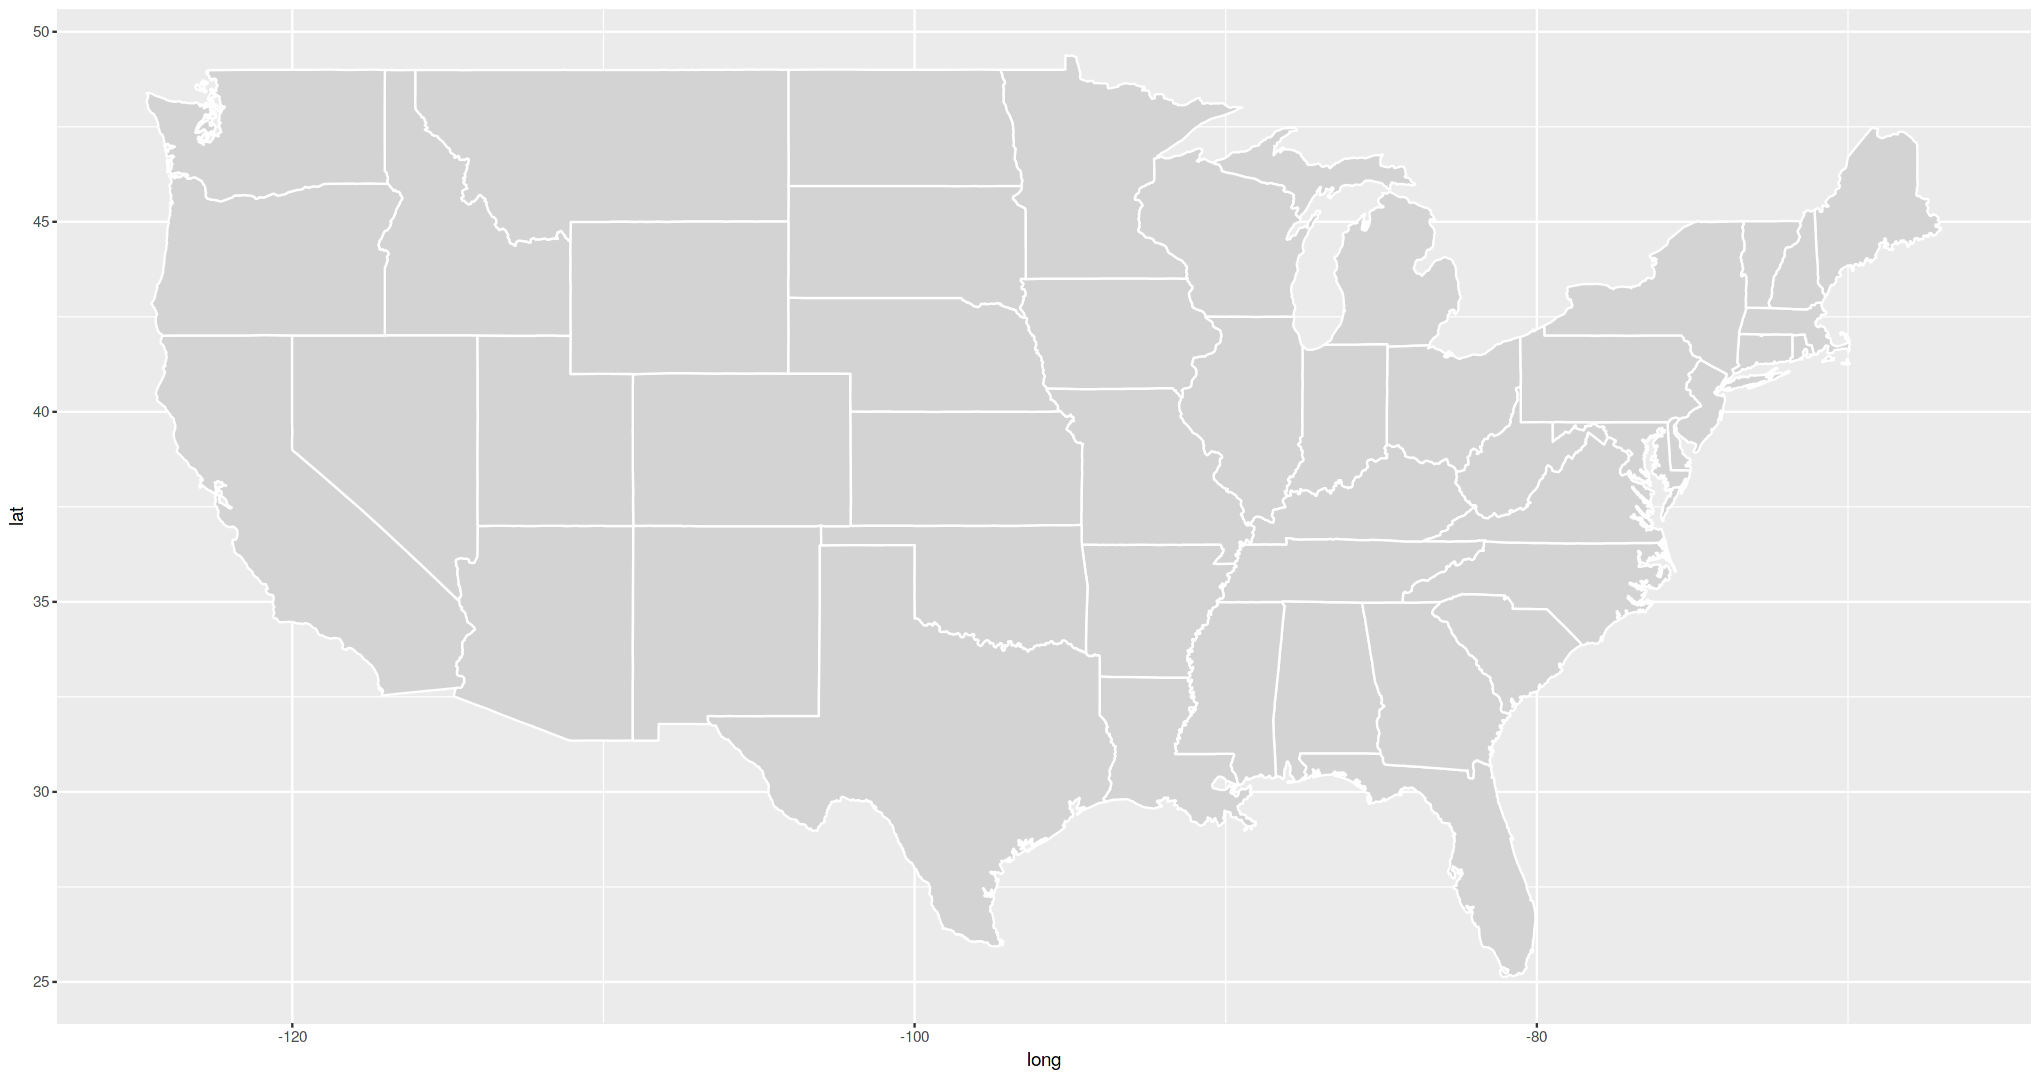

In [2]:
options(repr.plot.width = 17, repr.plot.height = 9)

# WORLD MAP
world_map <- map_data("world")
ggplot(world_map, aes(x = long, y = lat, group = group)) +
  geom_polygon()

# US MAP 
usa <- map_data("state")
ggplot(usa, aes(x = long, y = lat, group = group)) +
  geom_polygon(fill="lightgray", colour = "white")

<a id="section3"></a>
# 3.Election Data & First Map

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "State"

`summarise()` regrouping output by 'region' (override with `.groups` argument)

Joining, by = c("region", "Abb", "Votes")

Joining, by = "region"



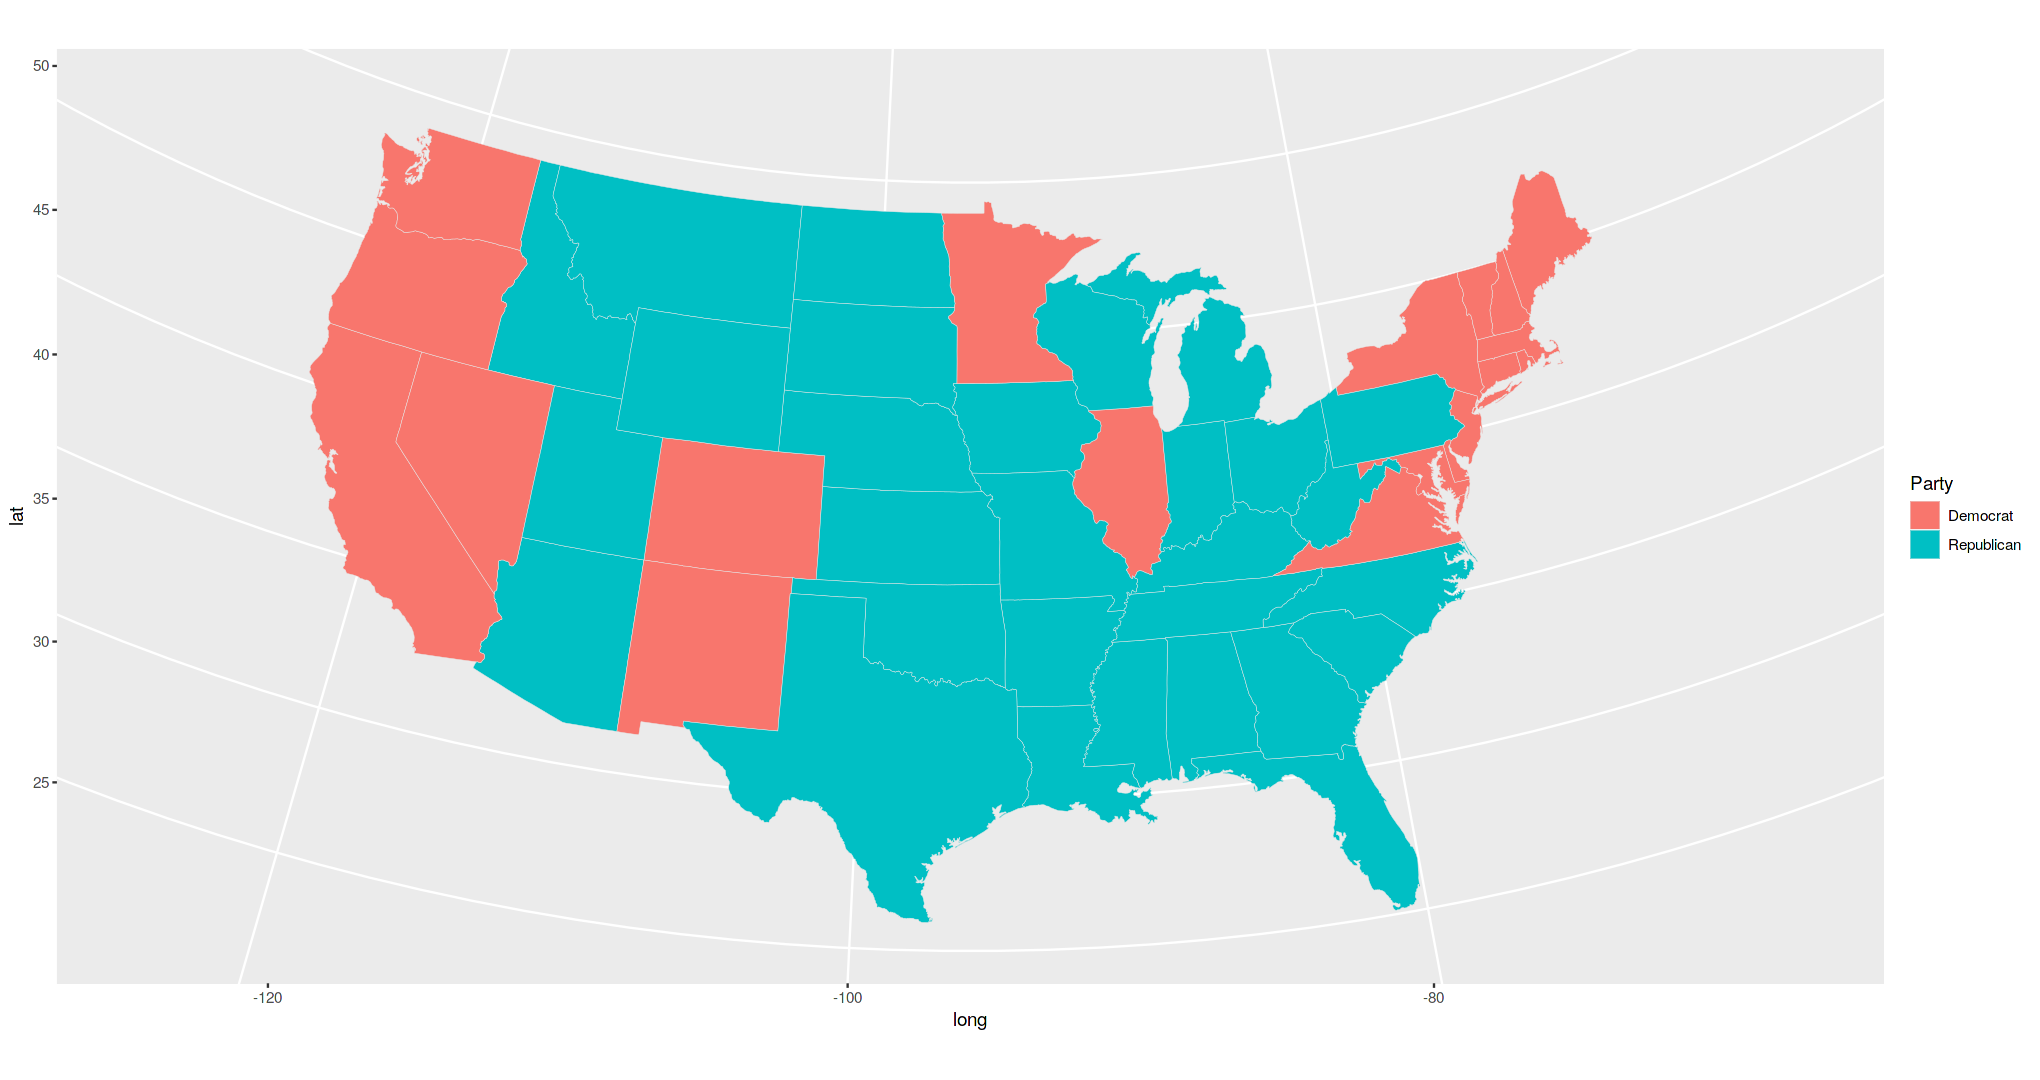

In [3]:
# RAW DATA
df <- read.csv("../input/2020-general-election-polls/nytimes_presidential_elections_2016_results_county.csv")

abb <- data.frame(State = state.name, Abb = state.abb)

# TOTAL VOTES
election <- df %>% 
  group_by(State) %>% 
  summarise(Clinton = sum(Clinton),
            Trump = sum(Trump)) %>% 
  ungroup() %>% 
  gather(Candidate, Votes, -State) %>% 
  mutate(Party = factor(if_else(Candidate == "Clinton", "Democrat", "Republican"))) %>% 
  left_join(abb) %>% 
  mutate(State = tolower(State)) %>% 
  rename("region" = State)

election2 <- election %>% 
  group_by(region, Abb) %>% 
  summarise(Votes = max(Votes)) %>% 
  ungroup() %>% 
  inner_join(election)

# Left Join for creating map
usa_election <- left_join(usa, election2) %>% 
  filter(!is.na(Party))


# First Map
p <- ggplot(data = usa_election, aes(x = long, y = lat))+
        geom_polygon(aes(group = group, fill = Party),color = "gray90", size = 0.1) +
        coord_map(projection = "albers", lat0 = 39, lat1 = 45) 
p

<a id="section4"></a>
# 4.Trump vs Clinton

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



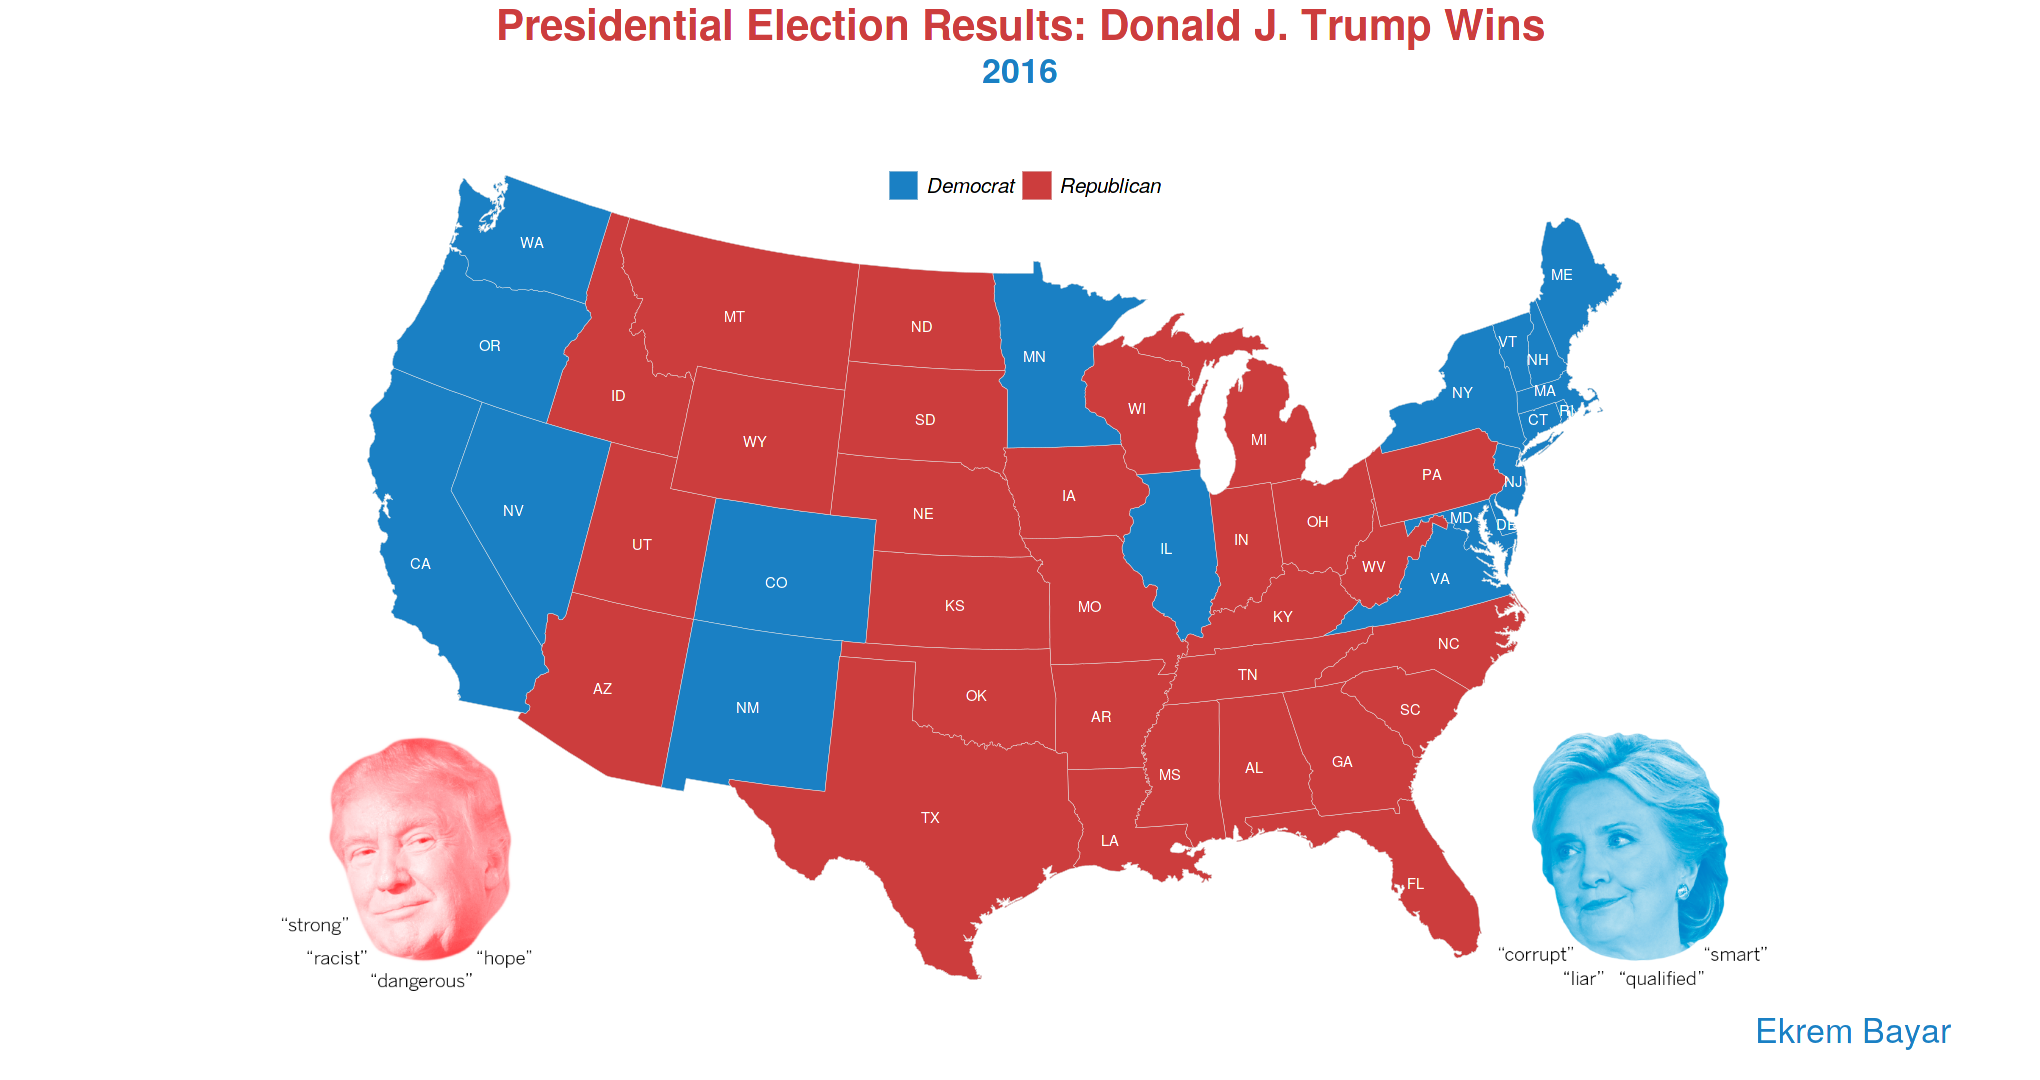

In [4]:
centroids <- data.frame(abb=state.abb, long=state.center$x, lat=state.center$y) %>% 
  filter(abb %in% unique(usa_election$Abb))


p1 <- p + geom_polygon(aes(group = group, fill = Party), color = "gray90", size = 0.1) +
    geom_text(aes(label = abb), data = centroids,  size = 3, color = "white", hjust = 1)+
    coord_map(projection = "albers", lat0 = 39, lat1 = 100) +
    scale_fill_manual(values = c("#1a80c4", "#cc3d3d"))+
    theme_void()+
    theme(
      legend.position = c(0.5, 0.9), legend.direction = "horizontal",
      legend.text = element_text(size = 12, face = "italic"),
      plot.title = element_text(hjust = 0.5, face = "bold", color = "#cc3d3d", size = 25),
      plot.subtitle = element_text(hjust = 0.5, face = "bold", color = "#1a80c4", size = 20),
      plot.caption = element_text(size = 20, vjust = 5, color ="#1a80c4")
      )+
    labs(title = "Presidential Election Results: Donald J. Trump Wins",
         subtitle = 2016,
         fill = NULL,
         caption = "Ekrem Bayar")

options(repr.plot.width = 17, repr.plot.height = 9)

ggdraw() +
  draw_image("../input/election/trump.png", scale = .25, x = -0.3, y = -0.3) +
  draw_image("../input/election/clinton.png", scale = .25, x = 0.3, y = -0.3) +
  draw_plot(p1)

<a id="section5"></a>
# 5.Statebins

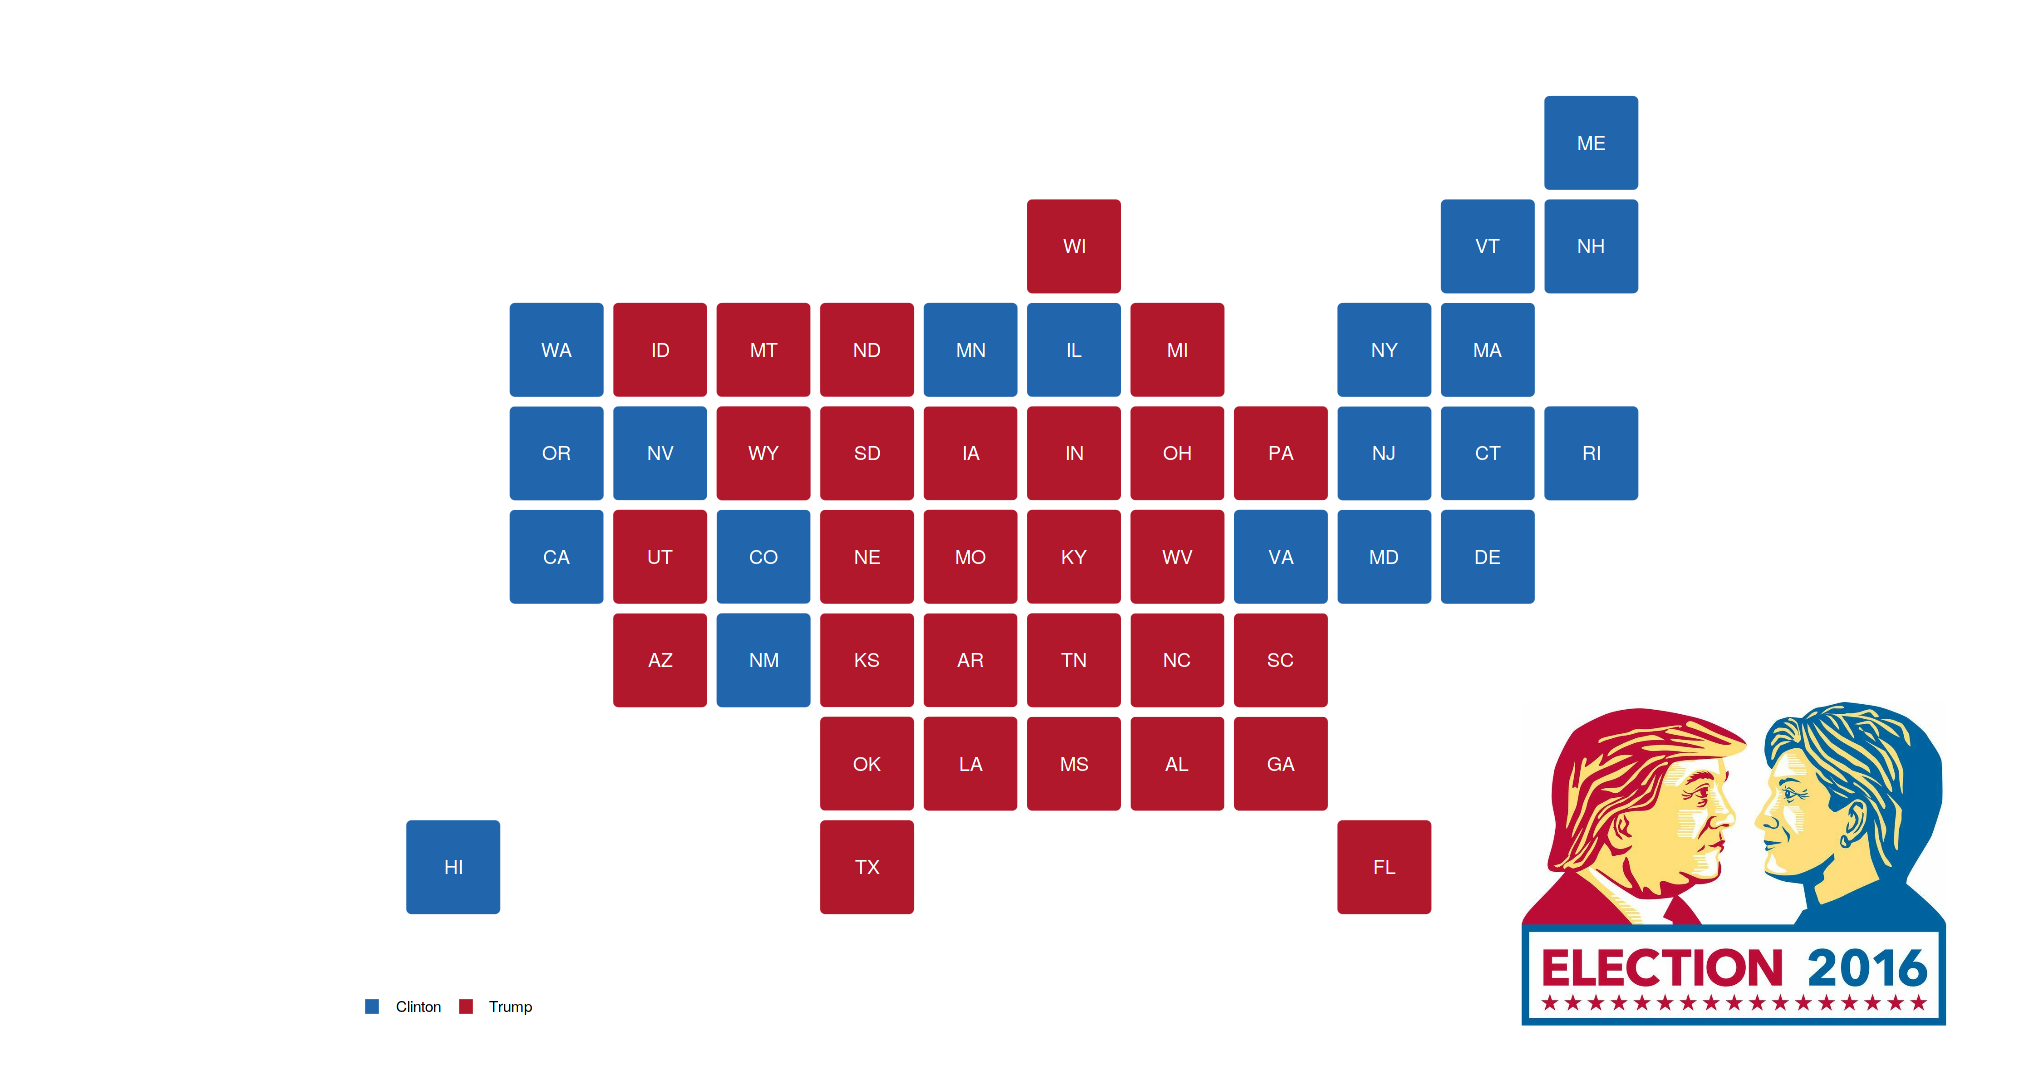

In [5]:
p2 <- election2 %>% 
  select(Abb, Votes, Candidate) %>% 
  spread(Candidate, Votes) %>% 
  mutate(value = ifelse(is.na(Clinton), "Trump", "Clinton")) %>% 
  rename("state" = Abb) %>% 
  mutate_if(is.factor, as.character) %>% 
  statebins(
    font_size=4, dark_label = "white", light_label = "white",
    ggplot2_scale_function = scale_fill_manual,
    name = NULL,
    values = c(Clinton = "#2166ac", Trump = "#b2182b"),
    round = TRUE,
    #state_border_col = "black",state_border_size = 1
  ) +
  theme_statebins()


ggdraw() +
  draw_image("../input/election/Election2016.jpg", scale = .3, x = 0.35, y = -0.3) +
  draw_plot(p2)

<a id="section6"></a>
# 6.References

- https://socviz.co/maps.html
- https://github.com/hrbrmstr/statebins
- https://www.r-spatial.org/r/2018/10/25/ggplot2-sf.html
- https://geocompr.robinlovelace.net/adv-map.html
